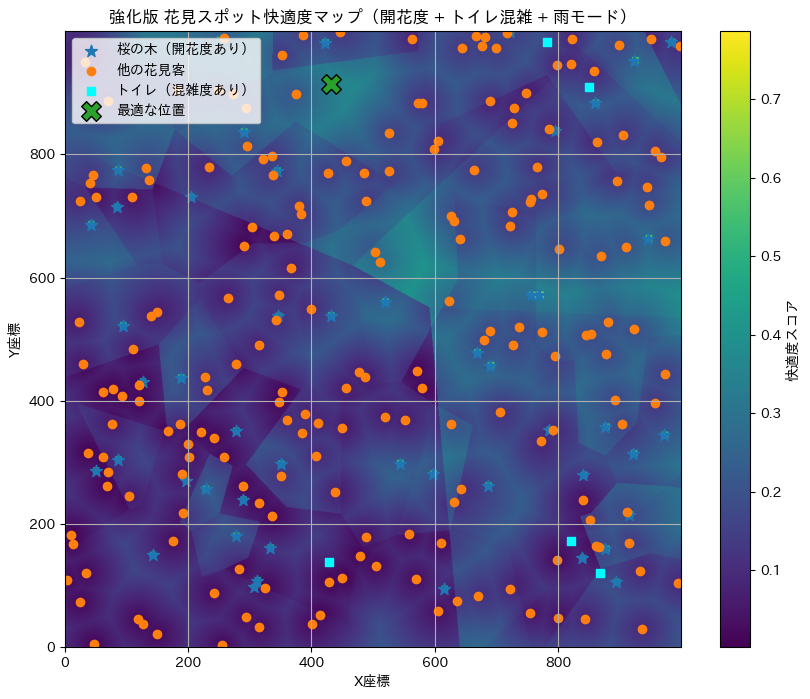

最適なスポット座標: (431, 914)
トイレの混雑度: [9, 0, 1, 3, 3]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from scipy.spatial.distance import cdist
from matplotlib import font_manager as fm
from IPython.display import HTML
import japanize_matplotlib


# ==== シミュレーション設定 ====
map_size = 1000
num_sakura = 50
num_people = 200
num_toilets = 5
rain_mode = True  # 雨の日モードON

# ==== ランダム配置 ====
sakura_coords = np.array([
    (random.randint(0, map_size - 1), random.randint(0, map_size - 1))
    for _ in range(num_sakura)
])
sakura_bloom = np.random.rand(num_sakura)  # 桜の開花度（0〜1）

people_coords = np.array([
    (random.randint(0, map_size - 1), random.randint(0, map_size - 1))
    for _ in range(num_people)
])
toilet_coords = np.array([
    (random.randint(0, map_size - 1), random.randint(0, map_size - 1))
    for _ in range(num_toilets)
])
toilet_congestion = np.random.randint(0, 10, size=num_toilets)  # 混雑度（0〜9）

# ==== グリッド生成 ====
grid_x, grid_y = np.meshgrid(np.arange(map_size), np.arange(map_size))
grid_coords = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# ==== 正規化関数 ====
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-6)

# ==== 桜のスコア（距離 + 開花度 + 雨の日ボーナス） ====
dist_to_sakura_all = cdist(grid_coords, sakura_coords)
nearest_idx = np.argmin(dist_to_sakura_all, axis=1)
dist_to_sakura = dist_to_sakura_all[np.arange(len(grid_coords)), nearest_idx]
bloom_at_nearest = sakura_bloom[nearest_idx]

if rain_mode:
    rain_bonus = np.exp(-dist_to_sakura)  # 木の真下が最高評価
else:
    rain_bonus = 0

sakura_score = (1 - normalize(dist_to_sakura)) * bloom_at_nearest + rain_bonus
sakura_score = normalize(sakura_score)  # 再正規化

# ==== 他人との距離スコア（遠いほど良い） ====
dist_to_people = np.min(cdist(grid_coords, people_coords), axis=1)
people_score = normalize(dist_to_people)

# ==== トイレスコア（距離 + 混雑度） ====
dist_to_toilet_all = cdist(grid_coords, toilet_coords)
nearest_toilet_idx = np.argmin(dist_to_toilet_all, axis=1)
dist_to_toilet = dist_to_toilet_all[np.arange(len(grid_coords)), nearest_toilet_idx]
congestion_at_nearest = toilet_congestion[nearest_toilet_idx]
toilet_penalty = normalize(congestion_at_nearest)  # 混雑しているとマイナス
toilet_distance_score = 1 - np.abs(normalize(dist_to_toilet) - 0.5) * 2
toilet_score = toilet_distance_score * (1 - toilet_penalty)

# ==== 桜密集度スコア ====
def compute_sakura_density(map_size, sakura_coords, radius=5):
    density = np.zeros((map_size, map_size))
    for x, y in sakura_coords:
        x_min = max(0, x - radius)
        x_max = min(map_size, x + radius + 1)
        y_min = max(0, y - radius)
        y_max = min(map_size, y + radius + 1)
        density[y_min:y_max, x_min:x_max] += 1
    return normalize(density)

sakura_density = compute_sakura_density(map_size, sakura_coords).ravel()

# ==== 総合スコアの計算（重み付き） ====
w_s = 0.3  # 桜（距離＋開花＋雨）
w_p = 0.2  # 他人との距離
w_t = 0.2  # トイレ
w_d = 0.3  # 桜密集度

score = (
    w_s * sakura_score +
    w_p * people_score +
    w_t * toilet_score +
    w_d * sakura_density
)
score_grid = score.reshape((map_size, map_size))

# ==== 最適な座標を取得 ====
best_idx = np.argmax(score)
best_coord = grid_coords[best_idx]

# ==== ヒートマップ表示 ====
plt.figure(figsize=(10, 8))
plt.imshow(score_grid, origin='lower')
plt.colorbar(label='快適度スコア')
plt.scatter(sakura_coords[:, 0], sakura_coords[:, 1], marker='*', label='桜の木（開花度あり）', s=80)
plt.scatter(people_coords[:, 0], people_coords[:, 1], marker='o', label='他の花見客')
plt.scatter(toilet_coords[:, 0], toilet_coords[:, 1], marker='s', label='トイレ（混雑度あり）', c='cyan')
plt.scatter(best_coord[0], best_coord[1], marker='X', s=200, label='最適な位置', edgecolors='black')
plt.title("強化版 花見スポット快適度マップ（開花度 + トイレ混雑 + 雨モード）")
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.legend()
plt.grid(True)
plt.show()

# ==== 出力：最適な座標とトイレ混雑度 ====
print(f"最適なスポット座標: {tuple(best_coord)}")
print(f"トイレの混雑度: {toilet_congestion.tolist()}")